### Dimensionality Reduction Review
#### Feature selection
##### 07Dec18
Using proportional downsampling techniques, get subsets of discrete and continous data to feature-select prior to running DR algorithms for comparison on relatively low-dimensional raw data.

In [36]:
from fcc_utils import *
from fcc_DRs import *

In [110]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [8]:
retina_1 = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1) # cells are columns in this raw datafile

In [9]:
retina_1.data.shape # see how many (cells, features) we are working with

(6600, 20478)

---
#### 0. perform 100-component PCA on arcsinh-transformed raw data

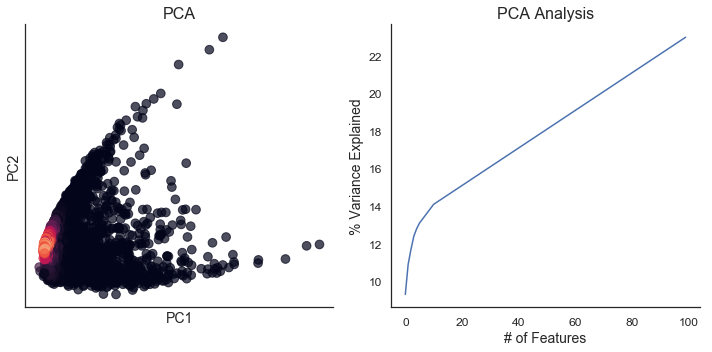

CPU times: user 31.5 s, sys: 4.68 s, total: 36.2 s
Wall time: 27.3 s


In [10]:
%%time
retina_1_PCA = fcc_PCA(retina_1.arcsinh_norm(), n_components=100)
retina_1_PCA.plot()

---
#### 1. perform t-SNE (perplexity 30) on PCA results and define clusters

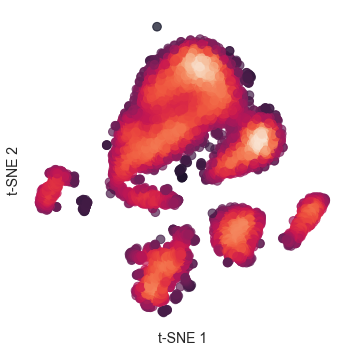

CPU times: user 1min 8s, sys: 2.07 s, total: 1min 11s
Wall time: 1min 11s


In [11]:
%%time
retina_1_tSNE = fcc_tSNE(retina_1_PCA.results, perplexity=30)
retina_1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12784dc18>)

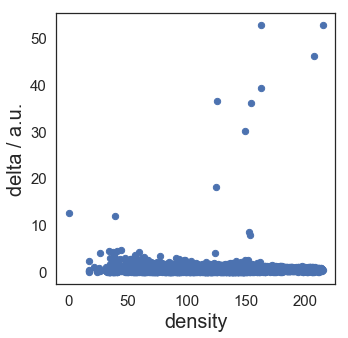

In [12]:
retina_1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ce96a58>)

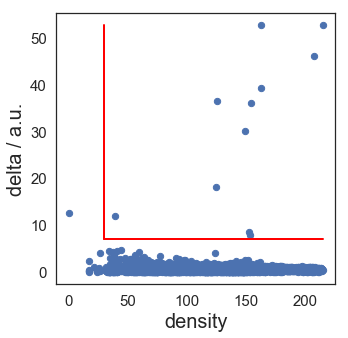

In [13]:
retina_1_tSNE.clu.assign(30, 7)
retina_1_tSNE.clu.draw_decision_graph(min_delta=retina_1_tSNE.clu.min_delta, min_density=retina_1_tSNE.clu.min_density)

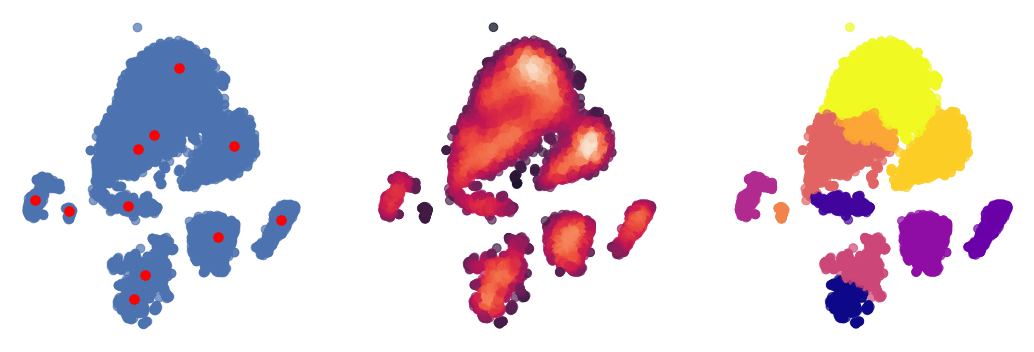

In [14]:
# visualize clustering
retina_1_tSNE.plot_clusters()

In [50]:
retina_1_tSNE.silhouette_score

0.39165106

---
#### 2. downsample dataset proportionally using predefined clusters from t-SNE above

In [76]:
# downsample to total of ~900 cells, maintaining cluster proportions so it (theoretically) clusters the same way when processed
retina_1_reduced = RNA_counts.downsample_proportional(counts_obj=retina_1, clu_membership=retina_1_tSNE.clu.membership, n_cells=900, seed=1)

In [77]:
retina_1_reduced.data.shape # should be slightly more than 900 cells because it rounds up to nearest cell number for each cluster proportion

(906, 20478)

Make sure the porportional downsampling worked by doing the same clustering as before

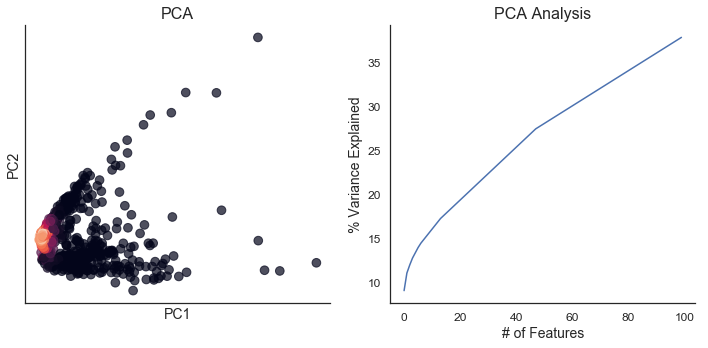

CPU times: user 3.56 s, sys: 494 ms, total: 4.05 s
Wall time: 2.33 s


In [78]:
%%time
retina_1_reduced_PCA = fcc_PCA(retina_1_reduced.arcsinh_norm(), n_components=100)
retina_1_reduced_PCA.plot()

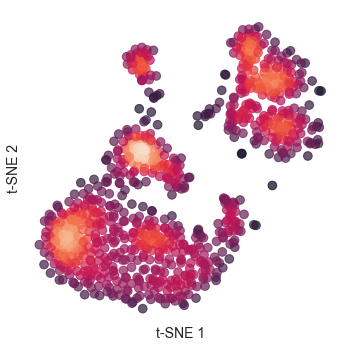

CPU times: user 5.03 s, sys: 90.4 ms, total: 5.12 s
Wall time: 4.97 s


In [79]:
%%time
retina_1_reduced_tSNE = fcc_tSNE(retina_1_reduced_PCA.results, perplexity=30)
retina_1_reduced_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122fc2b00>)

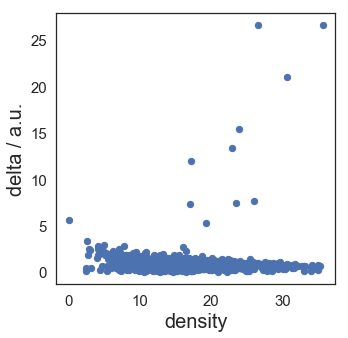

In [80]:
retina_1_reduced_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122cdfa20>)

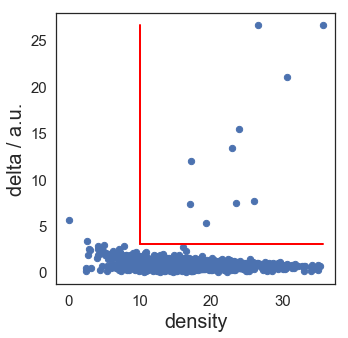

In [81]:
retina_1_reduced_tSNE.clu.assign(10, 3)
retina_1_reduced_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_tSNE.clu.min_delta, min_density=retina_1_reduced_tSNE.clu.min_density)

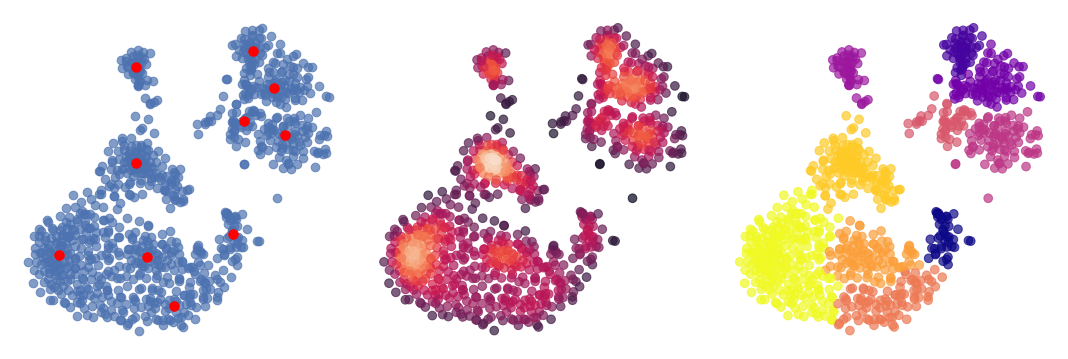

In [82]:
retina_1_reduced_tSNE.plot_clusters()

In [83]:
retina_1_reduced_tSNE.silhouette_score

0.44384018

---
#### 3. perform NVR feature selection on downsampled data

In [84]:
%time retina_1_reduced_nvr = RNA_counts.nvr_select(retina_1_reduced)

Start min_conn_k
3 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 372.1703760623932 seconds
done

Selected 697 variable genes



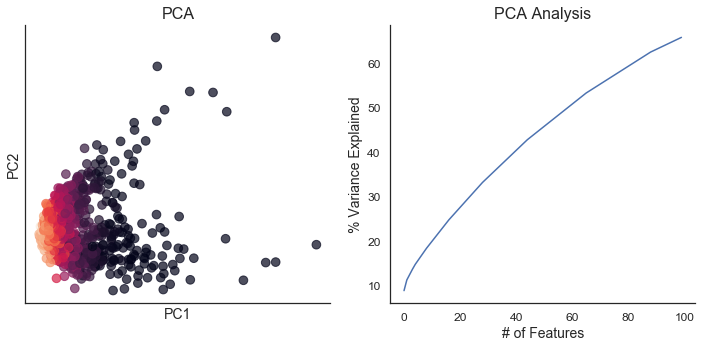

CPU times: user 896 ms, sys: 93 ms, total: 989 ms
Wall time: 530 ms


In [89]:
%%time
retina_1_reduced_nvr_PCA = fcc_PCA(retina_1_reduced_nvr.arcsinh_norm(), n_components=100)
retina_1_reduced_nvr_PCA.plot()

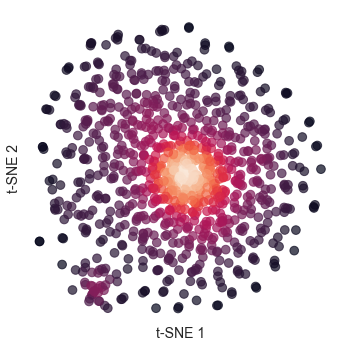

CPU times: user 5.86 s, sys: 193 ms, total: 6.06 s
Wall time: 5.93 s


In [90]:
%%time
retina_1_reduced_nvr_tSNE = fcc_tSNE(retina_1_reduced_nvr_PCA.results, perplexity=30)
retina_1_reduced_nvr_tSNE.plot()

NVR seems to make the resulting data 'lumpy'...  
Need to try another feature selection method

---
#### 3. perform ~~NVR~~ "brute force" feature selection on downsampled data

In [111]:
# let's select the top 600 most variable genes to mimic what NVR did
%time retina_1_reduced_select = RNA_counts.var_select(retina_1_reduced, 600)

CPU times: user 282 ms, sys: 186 ms, total: 467 ms
Wall time: 526 ms


In [126]:
retina_1_reduced_select.data.shape

(906, 600)

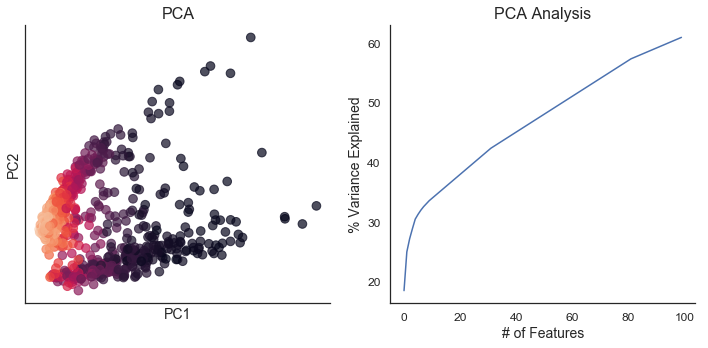

CPU times: user 881 ms, sys: 93.2 ms, total: 974 ms
Wall time: 510 ms


In [112]:
%%time
retina_1_reduced_select_PCA = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA.plot()

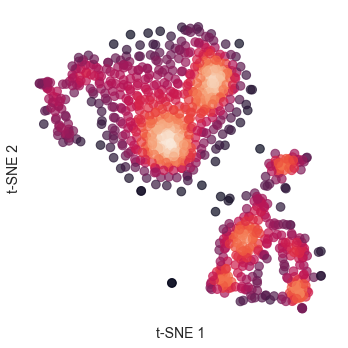

CPU times: user 5.34 s, sys: 149 ms, total: 5.49 s
Wall time: 5.38 s


In [113]:
%%time
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select_PCA.results, perplexity=30)
retina_1_reduced_select_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122fbf0f0>)

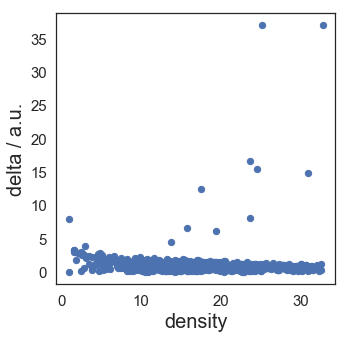

In [114]:
retina_1_reduced_select_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123e0f4e0>)

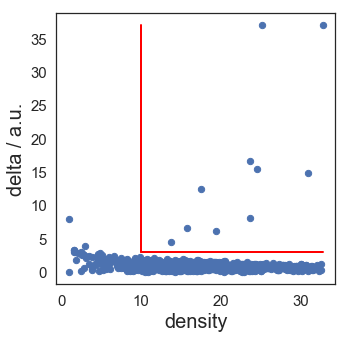

In [115]:
retina_1_reduced_select_tSNE.clu.assign(10,3)
retina_1_reduced_select_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_select_tSNE.clu.min_delta, min_density=retina_1_reduced_select_tSNE.clu.min_density)

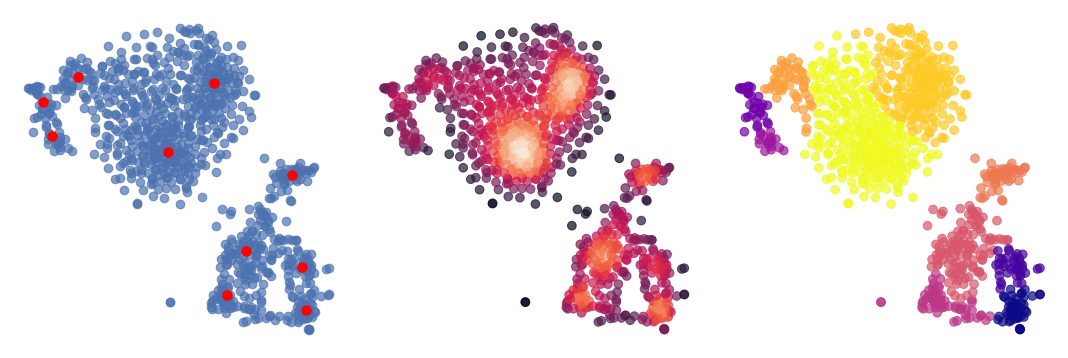

In [116]:
retina_1_reduced_select_tSNE.plot_clusters()

In [117]:
retina_1_reduced_select_tSNE.silhouette_score

0.36052448

So this seems to work better. Let's proceed.

---
#### 4. perform DR techniques on downsampled, feature-selected dataset and compare to original

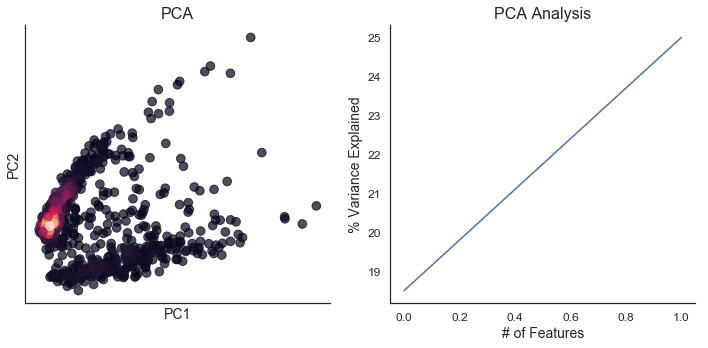

CPU times: user 698 ms, sys: 62.1 ms, total: 760 ms
Wall time: 427 ms


In [118]:
%%time
retina_1_reduced_select_PCA = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=2)
retina_1_reduced_select_PCA.plot()

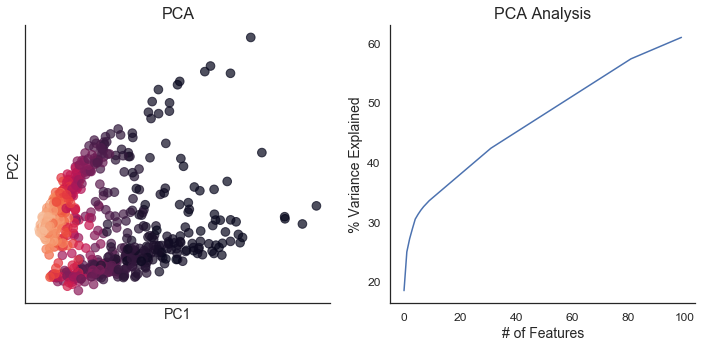

CPU times: user 898 ms, sys: 89.4 ms, total: 987 ms
Wall time: 530 ms


In [131]:
%%time
retina_1_reduced_select_PCA_100 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA_100.plot()

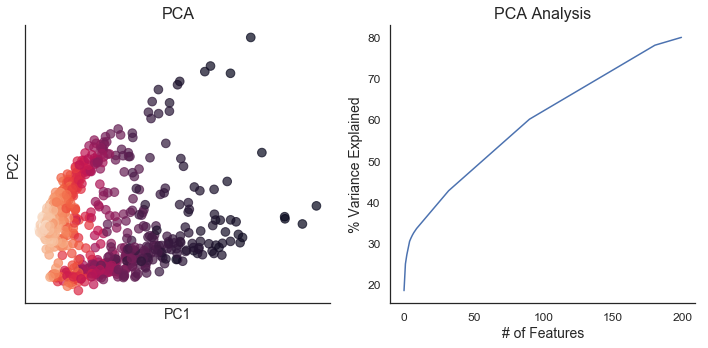

CPU times: user 1.02 s, sys: 102 ms, total: 1.12 s
Wall time: 589 ms


In [133]:
%%time
retina_1_reduced_select_PCA_200 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=200)
retina_1_reduced_select_PCA_200.plot()

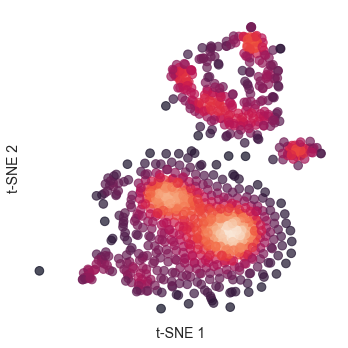

CPU times: user 6.16 s, sys: 139 ms, total: 6.29 s
Wall time: 6.22 s


In [119]:
%%time
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_tSNE.plot()

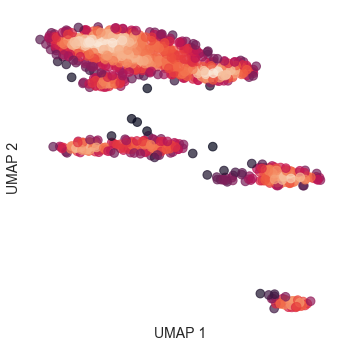

CPU times: user 7.39 s, sys: 293 ms, total: 7.68 s
Wall time: 7.84 s


In [120]:
%%time
retina_1_reduced_select_UMAP = fcc_UMAP(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_UMAP.plot()

In [129]:
%time retina_1_reduced_select_DCA = fcc_DCA(retina_1_reduced_select.counts)

DCA: Successfully preprocessed 600 genes and 906 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 14.9 s, sys: 765 ms, total: 15.7 s
Wall time: 9.7 s


##### Now compare the Euclidean distances in all the techniques

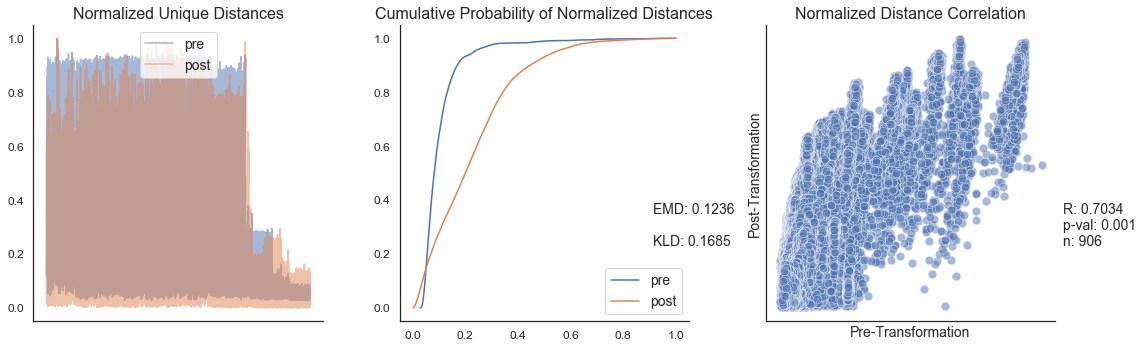

CPU times: user 20.4 s, sys: 3.36 s, total: 23.8 s
Wall time: 23.4 s


((0.7033870081257143, 0.001, 906), 0.12362717204370056, 0.1684551112879489)

In [123]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA.distance_matrix())

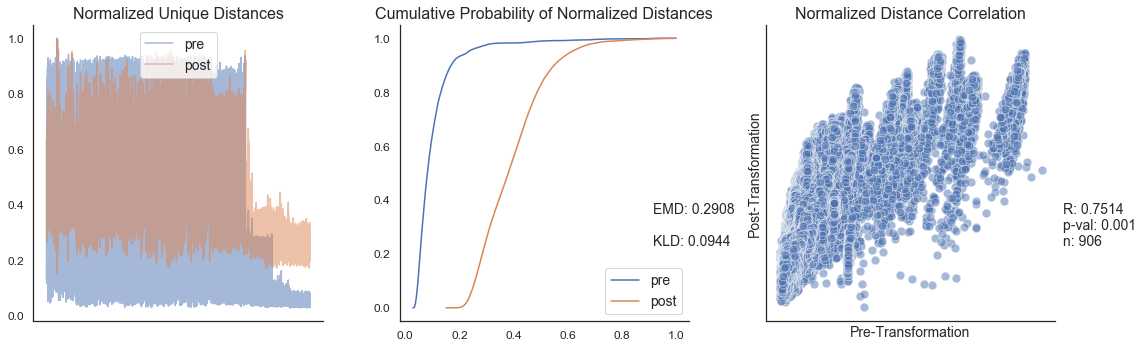

CPU times: user 20.6 s, sys: 3.2 s, total: 23.8 s
Wall time: 23.2 s


((0.7514249451088432, 0.001, 906), 0.29075823480972823, 0.09435673412574955)

In [132]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_100.distance_matrix())

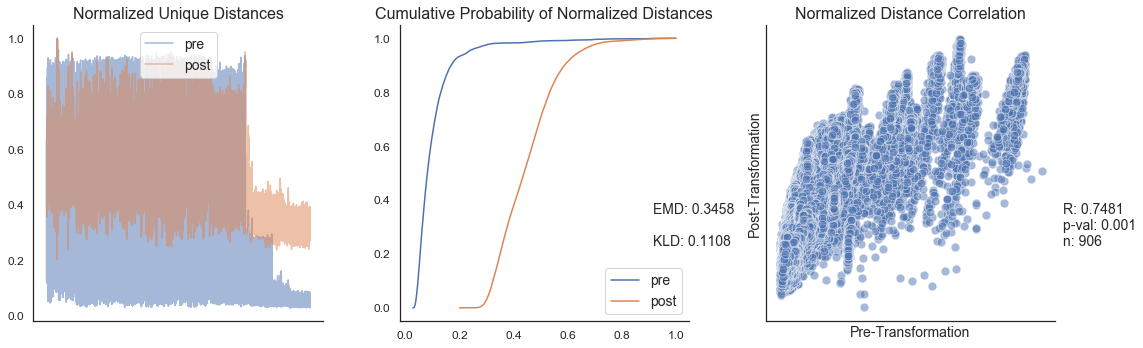

CPU times: user 20.2 s, sys: 3.08 s, total: 23.2 s
Wall time: 22.5 s


((0.7480594277696763, 0.001, 906), 0.34578240131597904, 0.11084452837718503)

In [134]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_200.distance_matrix())

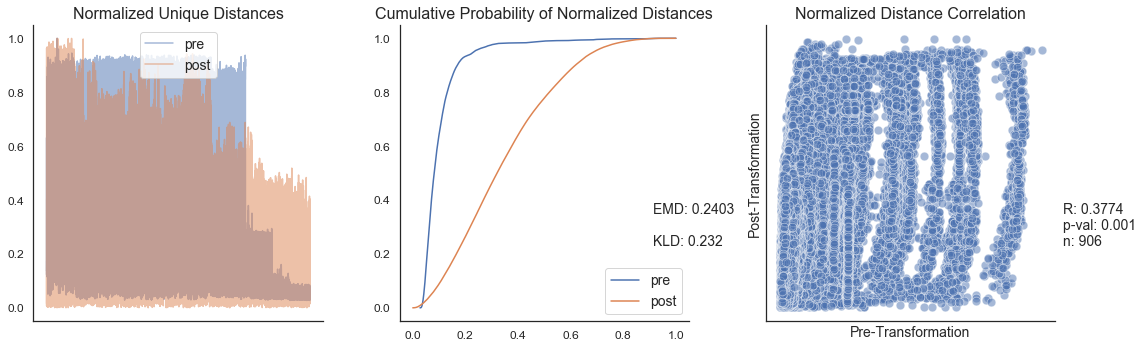

CPU times: user 20.3 s, sys: 3.23 s, total: 23.6 s
Wall time: 23.1 s


((0.37744682979605515, 0.001, 906), 0.24025485985080064, 0.23202956680015777)

In [124]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_tSNE.distance_matrix())

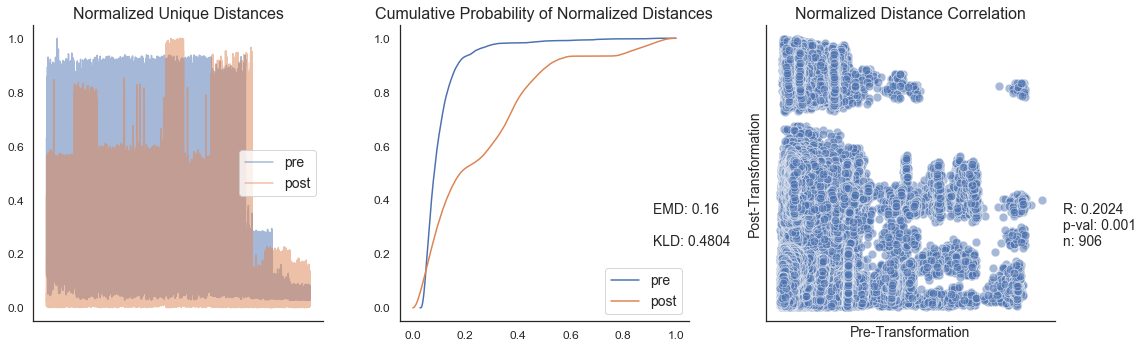

CPU times: user 20.3 s, sys: 4.07 s, total: 24.3 s
Wall time: 23.7 s


((0.20239989326925953, 0.001, 906), 0.16000175564527375, 0.48044495088802674)

In [125]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_UMAP.distance_matrix())

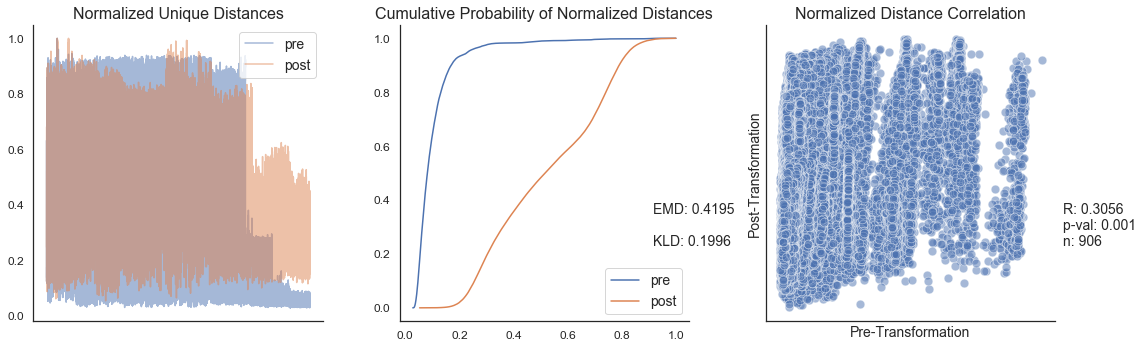

CPU times: user 21 s, sys: 3.55 s, total: 24.6 s
Wall time: 24 s


((0.30562198926351913, 0.001, 906), 0.41953435352580376, 0.19962898005447977)

In [130]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_DCA.distance_matrix())